proposed method

In [4]:
import numpy as np;
from sporco import linalg, util, metric, plot;
from torchvision import datasets;
import cv2;

In [5]:
# set options of experiments
def make_option():
    opt = {}
    opt['train_amount'] = 1000
    opt['test_amount'] = 1000
    return opt

In [6]:
def load_mnist_train(train_amount):
    data = datasets.MNIST("../data", download = True)
    imgs, labels = data.train_data.numpy() , data.train_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    return return_data[0:train_amount]/255.0, labels[0:train_amount]

def load_mnist_test(test_amount):
    data = datasets.MNIST("../data", download = True)
    imgs, labels = data.test_data.numpy(), data.test_labels.numpy()
    return_data = np.zeros((imgs.shape[0], 32, 32))
    for i in range(imgs.shape[0]):
        return_data[i] = cv2.copyMakeBorder(imgs[i],2,2,2,2,cv2.BORDER_CONSTANT, value=0)
    return return_data[0:test_amount]/255.0, labels[0:test_amount]

In [7]:
opt = make_option()
train_data, train_label = load_mnist_train(opt['train_amount'])
test_data, test_label = load_mnist_test(opt['test_amount'])
train_data = train_data.transpose(1,2,0)
test_data = test_data.transpose(1,2,0)

/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  4.52e+04  3.75e+04  1.53e+04  4.08e-16  6.04e-01  5.31e-01  2.55e+01  2.60e-01  3.73e-01  1.00e+01
   1  4.38e+04  3.77e+04  1.22e+04  2.54e-16  3.39e-01  6.21e-01  2.55e+01  1.51e-01  3.61e-01  1.00e+01
   2  3.90e+04  3.11e+04  1.57e+04  2.63e-16  2.03e-01  5.74e-01  2.55e+01  1.58e-01  2.59e-01  1.00e+01
   3  3.68e+04  2.69e+04  1.97e+04  2.30e-16  1.45e-01  5.14e-01  2.55e+01  1.20e-01  1.73e-01  1.00e+01
   4  3.43e+04  2.34e+04  2.17e+04  2.80e-16  9.08e-02  3.63e-01  2.55e+01  9.35e-02  1.28e-01  1.00e+01
   5  3.34e+04  2.18e+04  2.31e+04  3.35e-16  6.93e-02  2.77e-01  2.55e+01  7.32e-02  8.09e-02  1.00e+01
   6  3.24e+04  2.09e+04  2.31e+04  2.97e-16  5.09e-02  2.17e-01  2.55e+01  5.80e-02  5.81e-02  1.00e+01
   7  3.21e+04  2.04e+04  2.33e+04  3.88e-16  4.33e-02 

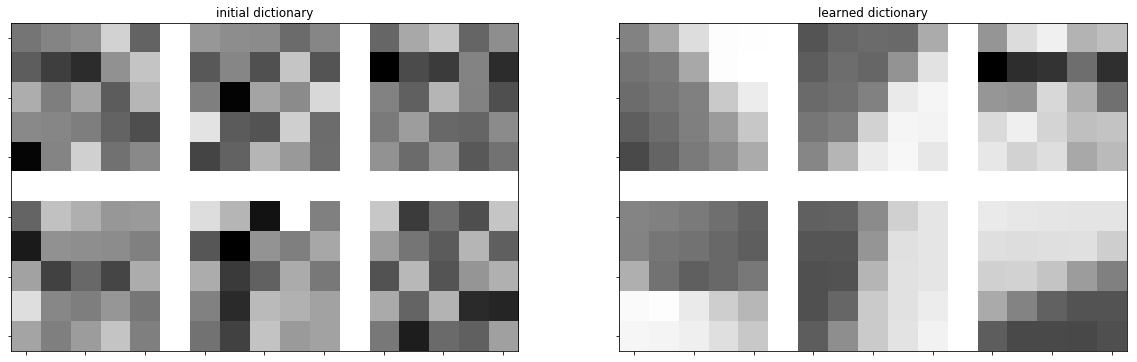

In [8]:
# first CDL layer

from sporco.dictlrn import cbpdndl;

np.random.seed(12345);
#define size of filters ---> (x,y,channel)
D0 = np.random.randn(5, 5, 6);

#execute dictionary learning
lmbda = 0.5;
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 50,
                            'CBPDN': {'rho': 50.0*lmbda + 0.5},
                            'CCMOD': {'rho': 10.0, 'ZeroMean': True}},
                            dmethod='cns');
d = cbpdndl.ConvBPDNDictLearn(D0, train_data, lmbda, opt, dmethod='cns');
#get dictionary(filters)
D1 = d.solve();
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'));

#compare trained filters with original
fig =  plot.figure(figsize=(20, 10));
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
plot.imview(util.tiledict(D0), fig=fig, ax=ax1, title="initial dictionary");
plot.imview(util.tiledict(D1.squeeze()), fig=fig, ax=ax2, title="learned dictionary");

#coef ---> sparse feature maps(x, y, number of filters, channel)
coef = np.array(d.getcoef().squeeze());

In [9]:
coef.shape

(32, 32, 1000, 6)

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.66e+03  5.66e+02  5.47e+04  7.00e-16  4.64e-01  9.42e-01  1.50e+00  1.00e-01  1.94e-01  1.00e+01
   1  1.57e+03  6.22e+02  4.76e+04  9.47e-16  2.36e-01  4.84e-01  1.50e+00  7.24e-02  2.11e-01  1.00e+01
   2  1.37e+03  4.73e+02  4.49e+04  8.25e-16  1.35e-01  2.59e-01  1.50e+00  6.15e-02  2.43e-01  1.00e+01
   3  1.31e+03  4.66e+02  4.21e+04  1.15e-15  9.30e-02  1.80e-01  1.50e+00  4.70e-02  2.31e-01  1.00e+01
   4  1.23e+03  4.30e+02  4.02e+04  8.77e-16  6.74e-02  1.32e-01  1.50e+00  3.94e-02  2.58e-01  1.00e+01
   5  1.20e+03  4.18e+02  3.90e+04  8.56e-16  5.31e-02  1.06e-01  1.50e+00  3.07e-02  2.43e-01  1.00e+01
   6  1.16e+03  3.99e+02  3.79e+04  8.13e-16  4.19e-02  8.86e-02  1.50e+00  2.54e-02  2.57e-01  1.00e+01
   7  1.13e+03  3.88e+02  3.71e+04  9.38e-16  3.51e-02 

ValueError: Argument img must be an Nr x Nc array or an Nr x Nc x 3 array

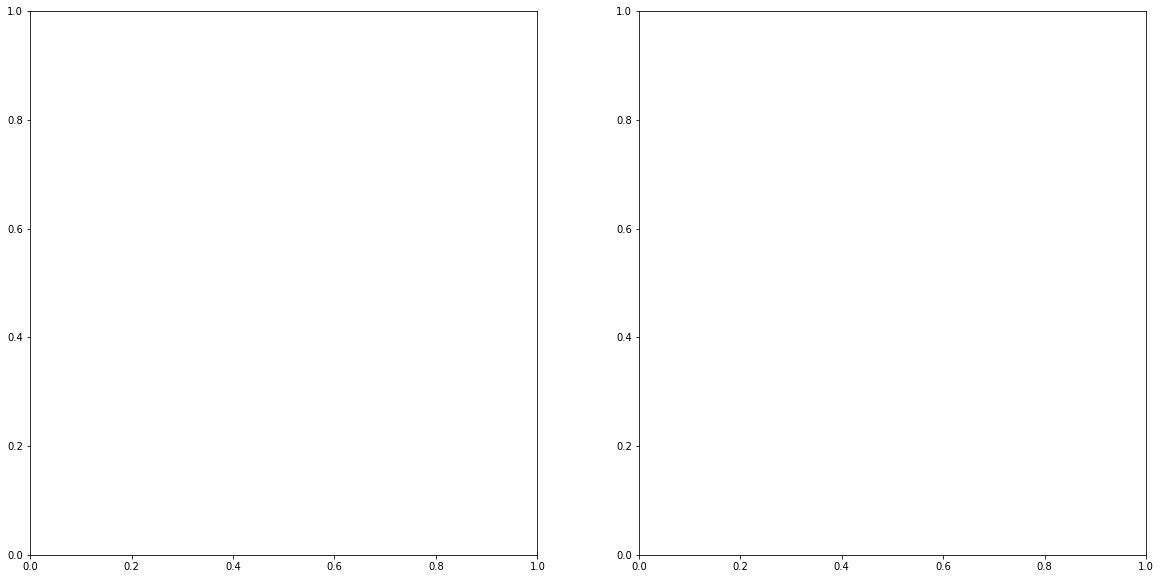

In [10]:
# second CDL layer

from sporco.dictlrn import cbpdndl;

np.random.seed(12345);
#channel in second layer is same as output of first layer
D0 = np.random.randn(5, 5, 6, 16);

lmbda = 0.02;
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 50,
                            'CBPDN': {'rho': 50.0*lmbda + 0.5},
                            'CCMOD': {'rho': 10.0, 'ZeroMean': True}},
                            dmethod='cns');
#input is output of first layer
d = cbpdndl.ConvBPDNDictLearn(D0, coef.transpose(0,1,3,2), lmbda, opt, dmethod='cns');
D2 = d.solve();
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'));


coef2 = np.array(d.getcoef().squeeze());

train SVM with exstracted features

exstract features from trained dictionary

In [12]:
train_data, train_label = load_mnist_train(5000)
print(train_data.shape)
train_data = train_data.transpose(1,2,0)
from sporco.admm import cbpdn

#coefficient maps estimation
#first layer
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

b1 = cbpdn.ConvBPDN(D1, train_data, lmbda, opt, dimK=0)
#get coefficient maps
X1 = b1.solve()
X1 = X1.squeeze()
print("ConvBPDN solve time: %.2fs" % b1.timer.elapsed('solve'))

/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/kuroki-lab/anaconda3/lib/python3.6/site-packages/torchvision-0.3.0-py3.6-linux-x86_64.egg/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


(5000, 32, 32)
Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  6.99e+04  4.69e+04  4.61e+05  3.63e-01  3.18e+00  3.50e+00
   1  6.23e+04  3.52e+04  5.42e+05  1.81e-01  1.11e+00  3.50e+00
   2  6.58e+04  3.41e+04  6.34e+05  2.48e-01  4.23e-01  1.19e+00
   3  6.53e+04  3.24e+04  6.58e+05  2.52e-01  2.44e-01  7.64e-01
   4  6.38e+04  3.23e+04  6.29e+05  2.20e-01  1.66e-01  6.52e-01
   5  6.21e+04  3.22e+04  5.97e+05  1.67e-01  1.30e-01  6.52e-01
   6  6.07e+04  3.21e+04  5.73e+05  1.30e-01  1.05e-01  6.52e-01
   7  5.93e+04  3.20e+04  5.47e+05  1.04e-01  8.94e-02  6.52e-01
   8  5.87e+04  3.20e+04  5.34e+05  9.06e-02  7.59e-02  5.90e-01
   9  5.79e+04  3.20e+04  5.19e+05  7.29e-02  6.52e-02  5.90e-01
  10  5.76e+04  3.19e+04  5.13e+05  6.57e-02  5.69e-02  5.24e-01
  11  5.72e+04  3.19e+04  5.07e+05  5.88e-02  4.91e-02  4.73e-01
  12  5.67e+04  3.19e+04  4.97e+05  4.84e-02  4.29e-02  4.73e-01
  13  5.65

In [13]:
# second layer
lmbda = 1e-1
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

b2 = cbpdn.ConvBPDN(D2.squeeze(), X1.transpose(0,1,3,2), lmbda, opt)
X2 = b2.solve()
X2 = X2.squeeze()
print("ConvBPDN solve time: %.2fs" % b2.timer.elapsed('solve'))
del X1

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  6.97e+04  3.30e+04  3.68e+05  5.86e-01  6.91e-01  6.00e+00
   1  6.74e+04  4.20e+04  2.54e+05  2.77e-01  4.99e-01  6.00e+00
   2  6.16e+04  3.29e+04  2.87e+05  2.28e-01  2.32e-01  3.16e+00
   3  6.53e+04  3.38e+04  3.15e+05  1.99e-01  1.67e-01  2.21e+00
   4  6.09e+04  3.05e+04  3.05e+05  1.62e-01  8.69e-02  1.71e+00
   5  5.87e+04  3.09e+04  2.78e+05  1.18e-01  5.38e-02  1.71e+00
   6  5.63e+04  3.05e+04  2.58e+05  8.95e-02  3.40e-02  1.71e+00
   7  5.42e+04  3.06e+04  2.37e+05  6.07e-02  2.31e-02  1.96e+00
   8  5.27e+04  3.05e+04  2.22e+05  4.16e-02  1.64e-02  2.25e+00
   9  5.18e+04  3.05e+04  2.13e+05  2.92e-02  1.24e-02  2.52e+00
  10  5.13e+04  3.05e+04  2.08e+05  2.32e-02  9.68e-03  2.52e+00
  11  5.09e+04  3.05e+04  2.04e+05  1.85e-02  7.81e-03  2.52e+00
  12  5.06e+04  3.05e+04  2.02e+05  1.48e-02  6.43e-03  2.52e+00
  13  5.04e+04  3.05e+04 

KeyboardInterrupt: 

In [ ]:
X2 = X2.transpose(0,1,3,2)
X2 = X2.reshape(-1,X2.shape[3])
from sklearn.svm import SVC
clf = SVC(gamma='auto',kernel='linear')
clf.fit(X2.T, train_label)

In [ ]:
print(clf.score(X2.T, train_label))
del X2
del train_label

test trained dictionary with test data

In [ ]:
from sporco.admm import cbpdn


#coefficient maps estimation
#first layer
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

b1 = cbpdn.ConvBPDN(D1, test_data, lmbda, opt, dimK=0)
X1 = b1.solve()
X1 = X1.squeeze()
print("ConvBPDN solve time: %.2fs" % b1.timer.elapsed('solve'))
del b1

In [ ]:
#second layer
lmbda = 1e-1
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

b2 = cbpdn.ConvBPDN(D2.squeeze(), X1.transpose(0,1,3,2), lmbda, opt)
X2 = b2.solve()
X2 = X2.squeeze()
print("ConvBPDN solve time: %.2fs" % b2.timer.elapsed('solve'))

In [ ]:
X2 = X2.transpose(0,1,3,2)
X2 = X2.reshape((-1,X2.shape[3]))
clf.score(X2.T, test_label)